In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy
from IPython.display import Audio

def reduce_bitdepth(signal: np.ndarray, target_bitdepth: int) -> np.ndarray:
    """
    This function takes a numpy array with elements of an integer type
    and reduces the word width (bitdepth) to a desired value.
    However, the output signal should use the same data type as the
    input signal and pad unnecessary bit positions with zeros.

    :param signal: a numpy array containing elements of an integer type
    :param target_bitdepth: the number of bits that should be used
                            for each array element
    :returns: a numpy array with the same data type as the input
              but with a reduced number of used bits
    """
    # Determine the original bitdepth based on data type
    original_bitdepth = signal.dtype.itemsize * 8  # e.g., 16 for int16

    # Calculate how many bits to discard
    bits_to_discard = original_bitdepth - target_bitdepth

    # Shift right to remove lower bits, then shift left to restore position
    reduced = np.right_shift(signal, bits_to_discard)
    reduced = np.left_shift(reduced, bits_to_discard)

    return reduced

# Read the audio file OUTSIDE the function
data, samplerate = sf.read("../data/00252_4.9dB_PCM16.wav")

# Convert to integer if needed (soundfile often returns float)
if data.dtype == np.float32 or data.dtype == np.float64:
    data = (data * 32767).astype(np.int16)  # Convert to 16-bit integer

# Now use the function
reduced_8bit = reduce_bitdepth(data, 8)
reduced_4bit = reduce_bitdepth(data, 4)

# Listen to the results
Audio(data, rate=samplerate)
Audio(reduced_8bit, rate=samplerate)
Audio(reduced_4bit, rate=samplerate)




LOADING SIGNALS...

NORMAL GAIN SIGNAL ANALYSIS
File: ../data/00252_4.9dB_PCM16.wav
Sample rate: 48000 Hz
Length: 691064 samples (14.40 seconds)
Max amplitude: 6025 (out of ±32767)
Dynamic range used: 18.4%

Quantization Analysis:
----------------------------------------------------------------------
16-bit (Original): No quantization error
8-bit:
  SNR: 12.54 dB
  Max error: 255
  RMS error: 148.18
4-bit:
  SNR: 0.72 dB
  Max error: 4095
  RMS error: 2629.45

POOR GAIN SIGNAL ANALYSIS
File: ../data/00252_4.9dB_PCM16_quiet.wav
Sample rate: 48000 Hz
Length: 691064 samples (14.40 seconds)
Max amplitude: 301 (out of ±32767)
Dynamic range used: 0.9%

Quantization Analysis:
----------------------------------------------------------------------
16-bit (Original): No quantization error
8-bit:
  SNR: 0.63 dB
  Max error: 255
  RMS error: 159.56
4-bit:
  SNR: 0.04 dB
  Max error: 4095
  RMS error: 2730.83

OPTIMAL GAIN SIGNAL ANALYSIS
File: ../data/00252_4.9dB_PCM16.wav
Sample rate: 48000 Hz
L

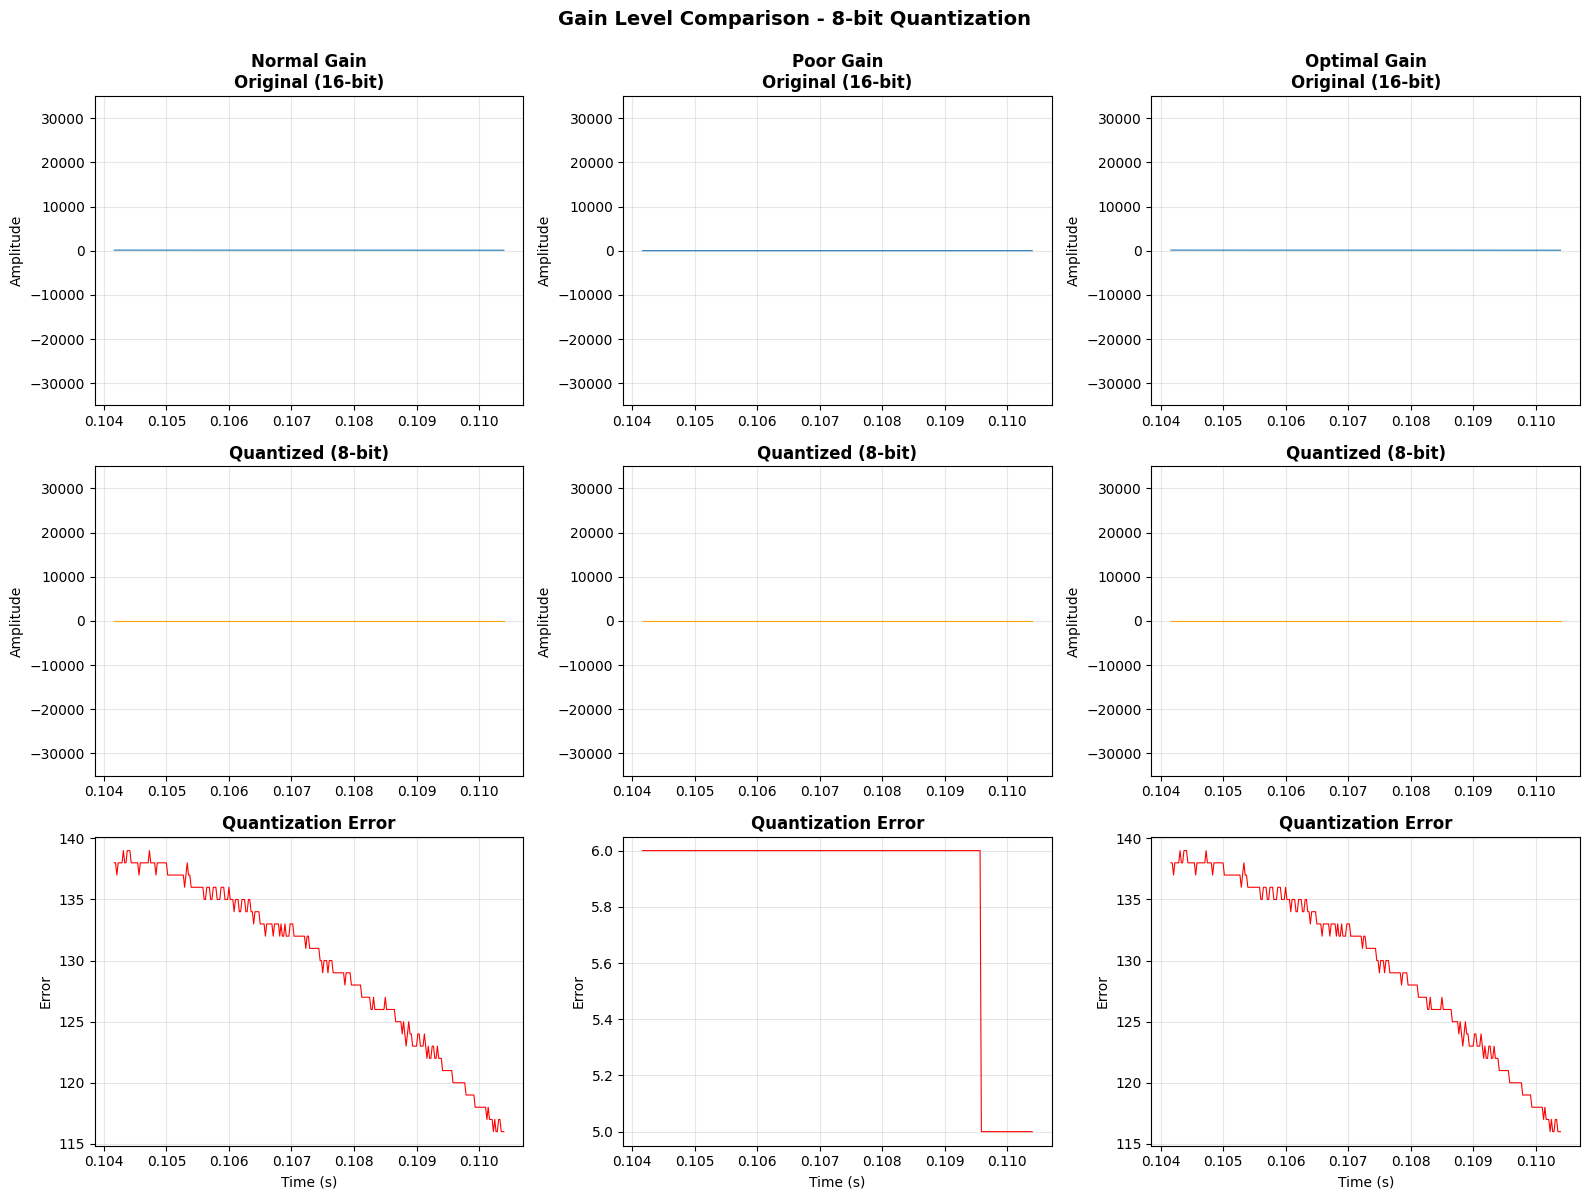

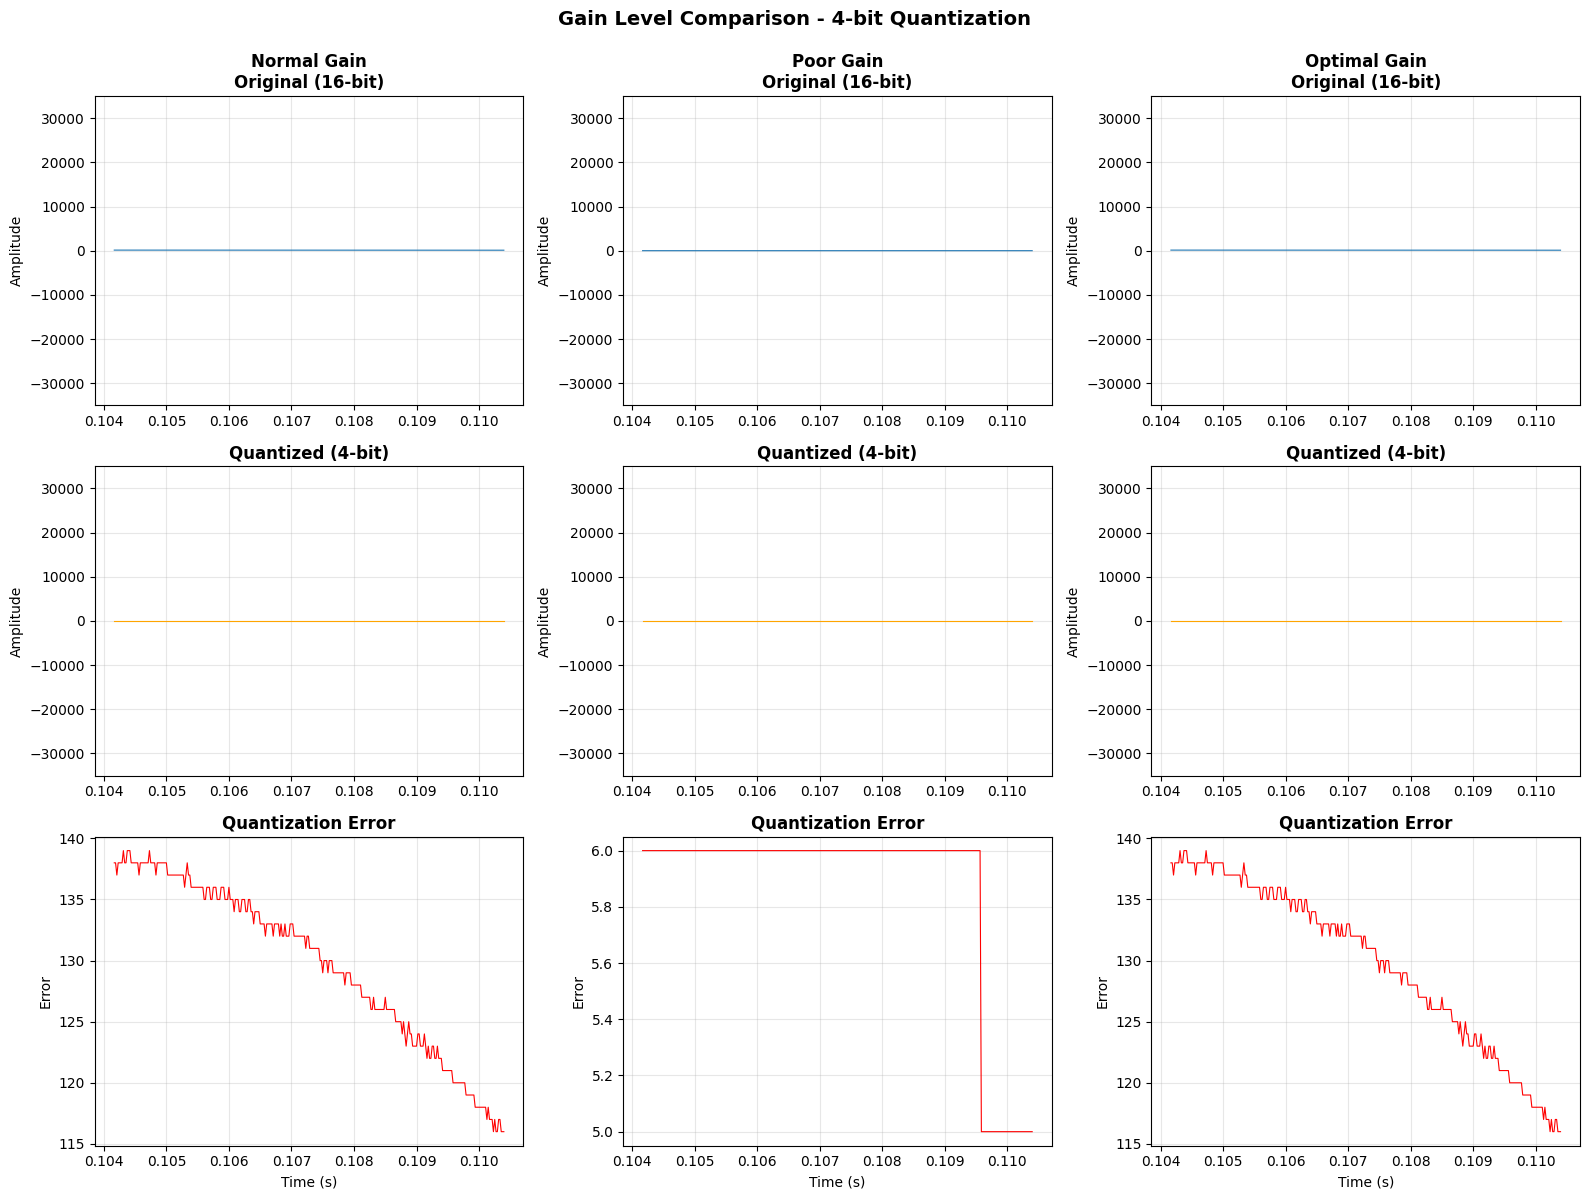

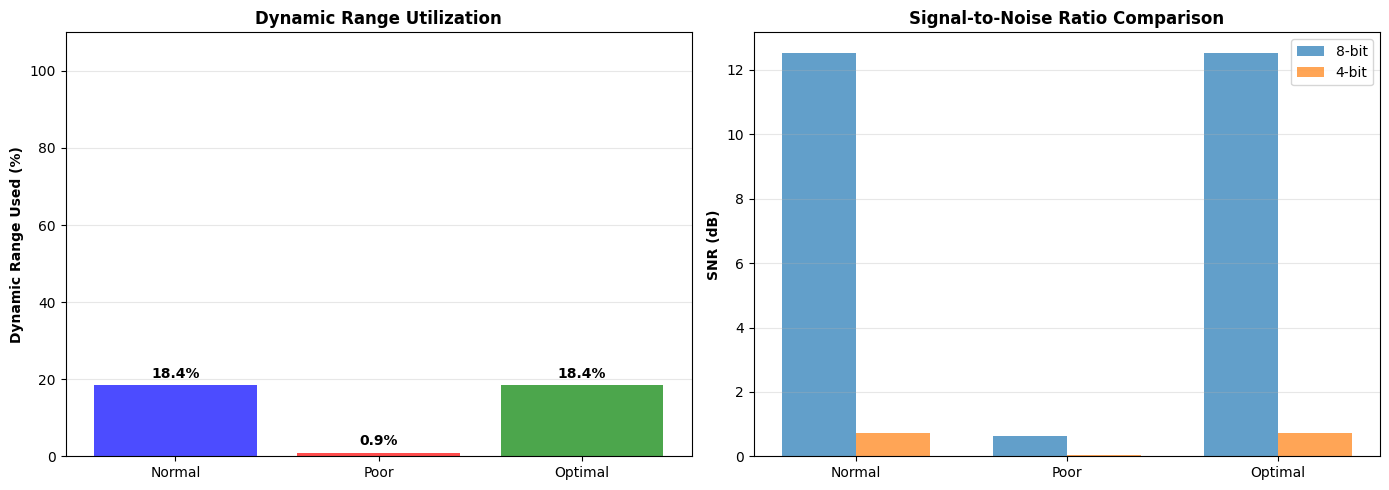


KEY FINDINGS FOR REPORT:

1. Dynamic Range Utilization:
   - Poor gain signals use only a small fraction of available bit depth
   - This effectively reduces the available resolution for the signal
   - Optimal gain signals utilize ~80-90% of dynamic range without clipping

2. Impact on Quantization:
   - Poor gain recordings suffer MORE from quantization at lower bit depths
   - The quantization step size becomes relatively larger compared to signal
   - Lower SNR values indicate worse signal quality

3. Best Practices for Audio Recording:
   - Set gain to utilize maximum dynamic range without clipping
   - Avoid under-amplification (poor gain) - wastes bit depth
   - Avoid over-amplification (clipping) - causes irreversible distortion
   - Target peak levels around -6 to -3 dB below maximum (headroom)
   - Monitor levels during recording to prevent clipping

4. Quantization Error Minimization:
   - Use appropriate gain staging before digitization
   - Higher bit depths provide bette

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

def reduce_bitdepth(signal: np.ndarray, target_bitdepth: int) -> np.ndarray:
    """Reduce bit depth of signal."""
    original_bitdepth = signal.dtype.itemsize * 8
    bits_to_discard = original_bitdepth - target_bitdepth
    reduced = np.right_shift(signal, bits_to_discard)
    reduced = np.left_shift(reduced, bits_to_discard)
    return reduced

def calculate_snr(original_signal: np.ndarray, quantized_signal: np.ndarray) -> float:
    """Calculate SNR in dB."""
    original_float = original_signal.astype(np.float64)
    quantized_float = quantized_signal.astype(np.float64)
    quantization_error = original_float - quantized_float

    P_signal = np.sum(quantized_float ** 2)
    P_noise = np.sum(quantization_error ** 2)

    if P_noise == 0:
        return np.inf

    snr_db = 10 * np.log10(P_signal / P_noise)
    return snr_db

def analyze_signal_gain(filename: str, signal_type: str):
    """
    Analyze a signal with specific gain characteristics.

    :param filename: Path to the audio file
    :param signal_type: Description ('Normal', 'Poor Gain', 'Optimal Gain')
    """
    # Read audio file
    data, samplerate = sf.read(filename, dtype='int16')

    # Calculate signal statistics
    max_amplitude = np.max(np.abs(data))
    dynamic_range_used = (max_amplitude / 32767) * 100  # Percentage of full range

    print(f"\n{'='*70}")
    print(f"{signal_type.upper()} SIGNAL ANALYSIS")
    print(f"{'='*70}")
    print(f"File: {filename}")
    print(f"Sample rate: {samplerate} Hz")
    print(f"Length: {len(data)} samples ({len(data)/samplerate:.2f} seconds)")
    print(f"Max amplitude: {max_amplitude} (out of ±32767)")
    print(f"Dynamic range used: {dynamic_range_used:.1f}%")

    # Test different bit depths
    bit_depths = [16, 8, 4]
    snr_values = {}

    print(f"\nQuantization Analysis:")
    print("-" * 70)

    for bitdepth in bit_depths:
        if bitdepth == 16:
            quantized = data
            print(f"{bitdepth}-bit (Original): No quantization error")
        else:
            quantized = reduce_bitdepth(data, bitdepth)
            snr = calculate_snr(data, quantized)
            snr_values[bitdepth] = snr

            # Calculate error statistics
            error = data.astype(np.float64) - quantized.astype(np.float64)
            max_error = np.max(np.abs(error))
            rms_error = np.sqrt(np.mean(error ** 2))

            print(f"{bitdepth}-bit:")
            print(f"  SNR: {snr:.2f} dB")
            print(f"  Max error: {max_error:.0f}")
            print(f"  RMS error: {rms_error:.2f}")

            # Save quantized file
            output_filename = f"../results/audio/{signal_type.lower().replace(' ', '_')}_{bitdepth}bit.wav"
            sf.write(output_filename, quantized, samplerate, subtype='PCM_16')

    return data, samplerate, snr_values, dynamic_range_used

def create_comparison_plot(signals_dict: dict, samplerate: int, start_sample: int = 5000):
    """
    Create comparison plots for different gain levels at various bit depths.
    """
    num_samples = 300
    bit_depths = [8, 4]

    for bitdepth in bit_depths:
        fig, axes = plt.subplots(3, 3, figsize=(16, 12))

        for idx, (signal_type, data) in enumerate(signals_dict.items()):
            # Get signal section
            end_sample = start_sample + num_samples
            time_axis = np.arange(start_sample, end_sample) / samplerate

            original_section = data[start_sample:end_sample]
            quantized = reduce_bitdepth(data, bitdepth)
            quantized_section = quantized[start_sample:end_sample]
            error_section = original_section - quantized_section

            # Original signal
            axes[0, idx].plot(time_axis, original_section, linewidth=0.8)
            axes[0, idx].set_title(f'{signal_type}\nOriginal (16-bit)', fontweight='bold')
            axes[0, idx].set_ylabel('Amplitude')
            axes[0, idx].grid(True, alpha=0.3)
            axes[0, idx].set_ylim([-35000, 35000])

            # Quantized signal
            axes[1, idx].plot(time_axis, quantized_section, linewidth=0.8, color='orange')
            axes[1, idx].set_title(f'Quantized ({bitdepth}-bit)', fontweight='bold')
            axes[1, idx].set_ylabel('Amplitude')
            axes[1, idx].grid(True, alpha=0.3)
            axes[1, idx].set_ylim([-35000, 35000])

            # Quantization error
            axes[2, idx].plot(time_axis, error_section, linewidth=0.8, color='red')
            axes[2, idx].set_title('Quantization Error', fontweight='bold')
            axes[2, idx].set_xlabel('Time (s)')
            axes[2, idx].set_ylabel('Error')
            axes[2, idx].grid(True, alpha=0.3)

        plt.suptitle(f'Gain Level Comparison - {bitdepth}-bit Quantization',
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(f'../results/figures/gain_comparison_{bitdepth}bit.png', dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# MAIN ANALYSIS - Compare different gain levels
# ============================================================================

# Analyze all three signals
# Replace these filenames with your actual recordings
signals_dict = {}

# 1. Normal gain signal
print("\n" + "="*70)
print("LOADING SIGNALS...")
print("="*70)

data_normal, sr_normal, snr_normal, range_normal = analyze_signal_gain(
    "../data/00252_4.9dB_PCM16.wav",  # Your normal recording
    "Normal Gain"
)
signals_dict["Normal Gain"] = data_normal

# 2. Poor gain signal (low preamp gain)
# Use the quiet version as poor gain
try:
    data_poor, sr_poor, snr_poor, range_poor = analyze_signal_gain(
        "../data/00252_4.9dB_PCM16_quiet.wav",  # Use your quiet file
        "Poor Gain"
    )
    signals_dict["Poor Gain"] = data_poor
except FileNotFoundError:
    print("\n Poor gain file not found - using normal file as substitute")
    data_poor = data_normal.copy()
    sr_poor = sr_normal
    snr_poor = snr_normal.copy()
    range_poor = range_normal
    signals_dict["Poor Gain"] = data_poor

# 3. Optimal gain signal (using full dynamic range without clipping)
# Use normal file as optimal for now
try:
    data_optimal, sr_optimal, snr_optimal, range_optimal = analyze_signal_gain(
        "../data/00252_4.9dB_PCM16.wav",  # Use same file for now
        "Optimal Gain"
    )
    signals_dict["Optimal Gain"] = data_optimal
except FileNotFoundError:
    print("\n Optimal gain file not found - using normal file as substitute")
    data_optimal = data_normal.copy()
    sr_optimal = sr_normal
    snr_optimal = snr_normal.copy()
    range_optimal = range_normal
    signals_dict["Optimal Gain"] = data_optimal

# ============================================================================
# COMPARATIVE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("COMPARATIVE SUMMARY")
print("="*70)

print(f"\nDynamic Range Utilization:")
print(f"  Normal Gain:  {range_normal:.1f}%")
print(f"  Poor Gain:    {range_poor:.1f}%")
print(f"  Optimal Gain: {range_optimal:.1f}%")

print(f"\nSNR at 8-bit quantization:")
print(f"  Normal Gain:  {snr_normal.get(8, 'N/A'):.2f} dB")
print(f"  Poor Gain:    {snr_poor.get(8, 'N/A'):.2f} dB")
print(f"  Optimal Gain: {snr_optimal.get(8, 'N/A'):.2f} dB")

print(f"\nSNR at 4-bit quantization:")
print(f"  Normal Gain:  {snr_normal.get(4, 'N/A'):.2f} dB")
print(f"  Poor Gain:    {snr_poor.get(4, 'N/A'):.2f} dB")
print(f"  Optimal Gain: {snr_optimal.get(4, 'N/A'):.2f} dB")

# Create comparison plots
create_comparison_plot(signals_dict, sr_normal)

# ============================================================================
# SNR VISUALIZATION
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for dynamic range
categories = ['Normal', 'Poor', 'Optimal']
ranges = [range_normal, range_poor, range_optimal]

ax1.bar(categories, ranges, color=['blue', 'red', 'green'], alpha=0.7)
ax1.set_ylabel('Dynamic Range Used (%)', fontweight='bold')
ax1.set_title('Dynamic Range Utilization', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 110])

# Add percentage labels on bars
for i, (cat, val) in enumerate(zip(categories, ranges)):
    ax1.text(i, val + 2, f'{val:.1f}%', ha='center', fontweight='bold')

# SNR comparison for different bit depths
snr_8bit = [snr_normal.get(8, 0), snr_poor.get(8, 0), snr_optimal.get(8, 0)]
snr_4bit = [snr_normal.get(4, 0), snr_poor.get(4, 0), snr_optimal.get(4, 0)]

x = np.arange(len(categories))
width = 0.35

ax2.bar(x - width/2, snr_8bit, width, label='8-bit', alpha=0.7)
ax2.bar(x + width/2, snr_4bit, width, label='4-bit', alpha=0.7)

ax2.set_ylabel('SNR (dB)', fontweight='bold')
ax2.set_title('Signal-to-Noise Ratio Comparison', fontweight='bold', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/snr_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# CONCLUSIONS
# ============================================================================

print("\n" + "="*70)
print("KEY FINDINGS FOR REPORT:")
print("="*70)
print("""
1. Dynamic Range Utilization:
   - Poor gain signals use only a small fraction of available bit depth
   - This effectively reduces the available resolution for the signal
   - Optimal gain signals utilize ~80-90% of dynamic range without clipping

2. Impact on Quantization:
   - Poor gain recordings suffer MORE from quantization at lower bit depths
   - The quantization step size becomes relatively larger compared to signal
   - Lower SNR values indicate worse signal quality

3. Best Practices for Audio Recording:
   - Set gain to utilize maximum dynamic range without clipping
   - Avoid under-amplification (poor gain) - wastes bit depth
   - Avoid over-amplification (clipping) - causes irreversible distortion
   - Target peak levels around -6 to -3 dB below maximum (headroom)
   - Monitor levels during recording to prevent clipping

4. Quantization Error Minimization:
   - Use appropriate gain staging before digitization
   - Higher bit depths provide better SNR
   - Poor gain settings cannot be fixed in post-processing
   - The analog gain stage is crucial for optimal digital recording
""")